### Step 1: Prerequisites and Dataset

In [ ]:
%pip install datasets torch torchvision tokenizer tiktoken matplotlib ipywidgets jupyter transformers

Note: you may need to restart the kernel to use updated packages.


### Step 2: Load Multiple Financial Datasets

In [ ]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

print("=" * 80)
print("FINANCIAL SLM - Multi-Dataset Preparation")
print("=" * 80)

# DATASET 1: Finance Alpaca (Instruction-following Q&A)
print("\n[1/3] Loading Finance Alpaca dataset...")
finance_alpaca = load_dataset("gbharti/finance-alpaca")
print(f"✓ Finance Alpaca loaded: {len(finance_alpaca['train']):,} examples")
print(f"  Purpose: Financial instruction-following and Q&A")

# DATASET 2: Financial PhraseBank (Sentiment Analysis)
print("\n[2/3] Loading Financial PhraseBank dataset...")
financial_phrasebank = load_dataset("atrost/financial_phrasebank")
print(f"✓ Financial PhraseBank loaded: {len(financial_phrasebank['train']):,} examples")
print(f"  Purpose: Financial sentiment understanding (positive/negative/neutral)")

sentiment_counts = {}
for example in financial_phrasebank['train']:
    label = example['label']
    sentiment_counts[label] = sentiment_counts.get(label, 0) + 1
print(f"  Sentiment distribution: {sentiment_counts}")

# DATASET 3: Custom Investment Dataset
print("\n[3/3] Creating custom investment recommendation dataset...")

custom_investment_data = [
    {
        "instruction": "Should I invest in this company?",
        "input": "Tech company, Revenue growth: 25% YoY, P/E ratio: 45, Debt-to-Equity: 0.3, Market cap: $50B",
        "output": "POSITIVE OUTLOOK - Consider investing. The 25% revenue growth indicates strong market demand. P/E of 45 is elevated but reasonable for high-growth tech. Low debt-to-equity (0.3) shows financial stability. Risk: High P/E means vulnerability to market corrections. Recommendation: Suitable for growth-oriented portfolios with 3-5 year horizon. Disclaimer: Not financial advice."
    },
    {
        "instruction": "Analyze this company's financial health",
        "input": "Manufacturing company, Operating margin: 8%, Current ratio: 1.5, ROE: 12%, Industry avg ROE: 10%",
        "output": "MODERATE HEALTH - The company shows decent performance. Operating margin of 8% is acceptable for manufacturing. Current ratio of 1.5 indicates adequate liquidity. ROE of 12% exceeds industry average (10%), suggesting efficient capital use. Consider for value portfolios. Monitor industry trends and competition."
    },
    {
        "instruction": "What are red flags in financial statements?",
        "input": "",
        "output": "Key red flags to watch: 1) Declining revenue with increasing receivables (fake sales), 2) Operating cash flow < Net income (earnings manipulation), 3) High debt-to-equity ratio >2.0 (financial risk), 4) Frequent auditor changes (governance issues), 5) Unusual related-party transactions, 6) Inventory growing faster than sales (obsolete stock). Always cross-verify with multiple quarters of data."
    },
    {
        "instruction": "Explain Price-to-Earnings ratio",
        "input": "",
        "output": "P/E ratio = Stock Price ÷ Earnings Per Share. It shows how much investors pay for each dollar of earnings. Example: P/E of 20 means investors pay $20 for $1 of annual earnings. Low P/E (<15): Potentially undervalued or mature company. High P/E (>25): Growth expectations or overvaluation. Compare within same industry. Tech averages 30+, utilities average 15-20."
    },
    {
        "instruction": "How to diversify investment portfolio?",
        "input": "Age: 30, Risk tolerance: Moderate, Investment horizon: 20 years",
        "output": "Recommended allocation for 30-year-old with moderate risk: 60% stocks (40% domestic large-cap, 15% international, 5% small-cap), 30% bonds (20% government, 10% corporate), 10% alternatives (REITs, commodities). Rebalance annually. Given 20-year horizon, can tolerate more equity risk. Gradually shift to conservative allocation approaching retirement. Dollar-cost average monthly to reduce timing risk."
    }
]

from datasets import Dataset
custom_dataset = Dataset.from_list(custom_investment_data)
print(f"✓ Custom investment dataset created: {len(custom_dataset)} examples")
print(f"  Purpose: Investment-specific reasoning and recommendations")

print("\n" + "=" * 80)

FINANCIAL SLM - Multi-Dataset Preparation

[1/3] Loading Finance Alpaca dataset...
✓ Finance Alpaca loaded: 68,912 examples
  Purpose: Financial instruction-following and Q&A

[2/3] Loading Financial PhraseBank dataset...
✓ Financial PhraseBank loaded: 3,100 examples
  Purpose: Financial sentiment understanding (positive/negative/neutral)
  Sentiment distribution: {2: 866, 0: 382, 1: 1852}

[3/3] Creating custom investment recommendation dataset...
✓ Custom investment dataset created: 5 examples
  Purpose: Investment-specific reasoning and recommendations



### Step 3: Format and Combine Datasets

In [ ]:
print("\n📝 Formatting datasets")

def format_text(example):
    """Unified formatting function"""
    text = f"""### Instruction:
{example['instruction']}

### Input:
{example['input']}

### Response:
{example['output']}

### End"""
    return {"text": text}

alpaca_formatted = finance_alpaca['train'].map(format_text, desc="Formatting Alpaca")
print(f"✓ Finance Alpaca formatted: {len(alpaca_formatted):,} examples")

datasets_to_combine = [alpaca_formatted]

def format_phrasebank(example):
    sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
    sentiment = sentiment_map[example['label']]
    
    return {
        "instruction": "Analyze the sentiment of this financial statement from an investor perspective.",
        "input": example['sentence'],
        "output": f"The sentiment of this statement is {sentiment}. This suggests the news may have a {sentiment} influence on stock price from an investor's viewpoint."
    }

phrasebank_with_fields = financial_phrasebank['train'].map(format_phrasebank, desc="Converting PhraseBank")
phrasebank_formatted = phrasebank_with_fields.map(format_text, desc="Formatting PhraseBank")
print(f"✓ Financial PhraseBank formatted: {len(phrasebank_formatted):,} examples")
datasets_to_combine.append(phrasebank_formatted)

custom_formatted = custom_dataset.map(format_text, desc="Formatting Custom")
print(f"✓ Custom dataset formatted: {len(custom_formatted)} examples")
datasets_to_combine.append(custom_formatted)

for i, ds in enumerate(datasets_to_combine):
    datasets_to_combine[i] = ds.remove_columns(
        [col for col in ds.column_names if col != 'text']
    )

combined_dataset = concatenate_datasets(datasets_to_combine)

print(f"\n✓ Combined dataset size: {len(combined_dataset):,} examples")
print("\n" + "=" * 80)


📝 Formatting datasets
✓ Finance Alpaca formatted: 68,912 examples
✓ Financial PhraseBank formatted: 3,100 examples


Formatting Custom:   0%|          | 0/5 [00:00<?, ? examples/s]

✓ Custom dataset formatted: 5 examples

✓ Combined dataset size: 72,017 examples



### Step 4: Create Train/Test Split

In [ ]:
print("\n✂️ Creating train/test split...")

dataset_split = combined_dataset.train_test_split(test_size=0.2, seed=42)

print(f"✓ Splits created:")
print(f"  - Train: {len(dataset_split['train']):,} examples")
print(f"  - Test: {len(dataset_split['test']):,} examples")

print("\n" + "=" * 80)


✂️ Creating train/test split...
✓ Splits created:
  - Train: 57,613 examples
  - Test: 14,404 examples



### Step 5: Tokenize the Combined Dataset

In [ ]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm
import tiktoken

print("\n⚙️ Tokenizing dataset...")

# Initialize GPT-2 tokenizer
encoder = tiktoken.get_encoding("gpt2")
print(f"✓ Tokenizer loaded: {encoder.name}")
print(f"  Vocabulary size: {encoder.n_vocab:,}")

def tokenize_example(example, encoder):
    """
    Convert text string to token IDs.
    Returns both the token IDs list and length for statistics.
    """
    ids = encoder.encode_ordinary(example["text"])
    return {"ids": ids, "len": len(ids)}

print("\nTokenizing train and test splits...")
tokenized = dataset_split.map(
    tokenize_example,
    fn_kwargs={"encoder": encoder},
    remove_columns=["text"],
    desc="Tokenizing",
    num_proc=os.cpu_count(),
)

print(f"\n✓ Tokenization complete!")
print(f"  Columns after tokenization: {tokenized['train'].column_names}")

print(f"\n📋 Sample tokenized example:")
print(f"  First 20 token IDs: {tokenized['train'][0]['ids'][:20]}")
print(f"  Token count: {tokenized['train'][0]['len']}")

train_tokens = np.sum(tokenized['train']['len'], dtype=np.int64)
test_tokens = np.sum(tokenized['test']['len'], dtype=np.int64)
total_tokens = train_tokens + test_tokens

print(f"\n📊 Token Statistics:")
print(f"  - Train tokens: {train_tokens:,}")
print(f"  - Test tokens: {test_tokens:,}")
print(f"  - Total tokens: {total_tokens:,}")
print(f"  - Avg tokens/example (train): {train_tokens / len(tokenized['train']):.1f}")
print(f"  - Avg tokens/example (test): {test_tokens / len(tokenized['test']):.1f}")
print(f"  - Max tokens in example: {max(tokenized['train']['len'])}")
print(f"  - Min tokens in example: {min(tokenized['train']['len'])}")

print("\n" + "=" * 80)


⚙️ Tokenizing dataset...
✓ Tokenizer loaded: gpt2
  Vocabulary size: 50,257

Tokenizing train and test splits...

✓ Tokenization complete!
  Columns after tokenization: ['ids', 'len']

📋 Sample tokenized example:
  First 20 token IDs: [21017, 46486, 25, 198, 37702, 2736, 262, 15598, 286, 428, 3176, 2643, 422, 281, 15811, 6650, 13, 198, 198, 21017]
  Token count: 120

📊 Token Statistics:
  - Train tokens: 7,684,648
  - Test tokens: 1,914,507
  - Total tokens: 9,599,155
  - Avg tokens/example (train): 133.4
  - Avg tokens/example (test): 132.9
  - Max tokens in example: 3543
  - Min tokens in example: 25



### Step 6: Load Tokenized Data Directly to RAM

In [ ]:
import torch

print("\n💾 Loading tokenized data to RAM")

train_data = torch.cat([
    torch.tensor(example['ids'], dtype=torch.long) 
    for example in tqdm(tokenized['train'], desc="Loading train")
])
print(f"✓ Train data: {len(train_data):,} tokens ({len(train_data)*8/1024/1024:.2f} MB)")

test_data = torch.cat([
    torch.tensor(example['ids'], dtype=torch.long) 
    for example in tqdm(tokenized['test'], desc="Loading test")
])
print(f"✓ Test data: {len(test_data):,} tokens ({len(test_data)*8/1024/1024:.2f} MB)")

def get_batch(split, batch_size, block_size, device, device_type):
    """Fast in-memory batch generation - no disk I/O"""
    data = train_data if split == 'train' else test_data
    
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])
    
    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    
    return x, y

print("✓ Data ready for training")
print("=" * 80)


💾 Loading tokenized data to RAM


Loading train:   0%|          | 0/57613 [00:00<?, ?it/s]

✓ Train data: 7,684,648 tokens (58.63 MB)


Loading test:   0%|          | 0/14404 [00:00<?, ?it/s]

✓ Test data: 1,914,507 tokens (14.61 MB)
✓ Data ready for training


### Step 7: Defining the model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

class LayerNorm(nn.Module):
    """LayerNorm with optional bias"""
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    """Multi-head causal self-attention"""
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        
        # Q, K, V projections for all heads in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        
        # Flash attention support (much faster)
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            # Causal mask for non-flash attention
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()  # batch, sequence length, embedding dim
        
        # Calculate Q, K, V for all heads in batch
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Efficient attention
        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, 
                                                dropout_p=self.attn_dropout.p if self.training else 0.0, 
                                                is_causal=True)
        else:
            # Manual attention computation
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    """Feed-forward network"""
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    """Transformer block: attention + MLP with residual connections"""
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    """GPT model configuration"""
    block_size: int       # Max sequence length
    vocab_size: int       # Vocabulary size
    n_layer: int          # Number of transformer blocks
    n_head: int           # Number of attention heads
    n_embd: int           # Embedding dimension
    dropout: float = 0.0  # Dropout rate
    bias: bool = True     # Use bias in linear layers

class GPT(nn.Module):
    """GPT Language Model"""
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),  # Token embeddings
            wpe=nn.Embedding(config.block_size, config.n_embd),  # Position embeddings
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        # Weight tying: share embeddings with output layer
        self.transformer.wte.weight = self.lm_head.weight

        # Initialize weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        
        pos = torch.arange(0, t, dtype=torch.long, device=device)
        
        # Forward pass
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # Training mode: compute loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            # Inference mode: only compute last token
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate new tokens autoregressively.
        
        Args:
            idx: Input token indices [B, T]
            max_new_tokens: Number of tokens to generate
            temperature: Sampling temperature (higher = more random)
            top_k: If set, only sample from top k most likely tokens
        """
        for _ in range(max_new_tokens):
            # Crop context if needed
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # Get predictions
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            
            # Optional top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            
            # Sample from distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        
        return idx



2025-10-28 21:17:56.629944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761686276.647435     327 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761686276.652432     327 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



LOADING PRETRAINED GPT-2
✓ Pretrained GPT-2 loaded (124M parameters)

✓ Model ready for fine-tuning
  Parameters: 124.44M
  Pretrained on: ~40GB of web text
  Now fine-tuning on: Financial data


In [ ]:
# Create model configuration for Financial SLM
config = GPTConfig(
    vocab_size=50257,
    block_size=1024,
    n_layer=8,
    n_head=12,
    n_embd=768,
    dropout=0.2,
    bias=True
)

model = GPT(config)

# Load pretrained GPT-2 weights from Hugging Face
print("\nLoading pretrained GPT-2 weights into custom model...")
from transformers import GPT2LMHeadModel

pretrained_hf = GPT2LMHeadModel.from_pretrained('gpt2')
pretrained_dict = pretrained_hf.state_dict()

# Map Hugging Face weights to your custom model
model_dict = model.state_dict()
mapped_dict = {}

# Weight mapping (Hugging Face → Your model)
weight_map = {
    # Token embeddings
    'transformer.wte.weight': 'transformer.wte.weight',
    # Position embeddings
    'transformer.wpe.weight': 'transformer.wpe.weight',
    # Final layer norm
    'transformer.ln_f.weight': 'transformer.ln_f.weight',
    'transformer.ln_f.bias': 'transformer.ln_f.bias',
    # Language model head
    'lm_head.weight': 'lm_head.weight',
}

# Copy embeddings and layer norm
for hf_key, custom_key in weight_map.items():
    if hf_key in pretrained_dict and custom_key in model_dict:
        mapped_dict[custom_key] = pretrained_dict[hf_key]
        print(f"  ✓ Loaded {custom_key}")

# Copy transformer blocks
for layer_idx in range(8):
    # Attention weights
    mapped_dict[f'transformer.h.{layer_idx}.attn.c_attn.weight'] = pretrained_dict[f'transformer.h.{layer_idx}.attn.c_attn.weight']
    mapped_dict[f'transformer.h.{layer_idx}.attn.c_attn.bias'] = pretrained_dict[f'transformer.h.{layer_idx}.attn.c_attn.bias']
    mapped_dict[f'transformer.h.{layer_idx}.attn.c_proj.weight'] = pretrained_dict[f'transformer.h.{layer_idx}.attn.c_proj.weight']
    mapped_dict[f'transformer.h.{layer_idx}.attn.c_proj.bias'] = pretrained_dict[f'transformer.h.{layer_idx}.attn.c_proj.bias']
    
    # MLP weights
    mapped_dict[f'transformer.h.{layer_idx}.mlp.c_fc.weight'] = pretrained_dict[f'transformer.h.{layer_idx}.mlp.c_fc.weight']
    mapped_dict[f'transformer.h.{layer_idx}.mlp.c_fc.bias'] = pretrained_dict[f'transformer.h.{layer_idx}.mlp.c_fc.bias']
    mapped_dict[f'transformer.h.{layer_idx}.mlp.c_proj.weight'] = pretrained_dict[f'transformer.h.{layer_idx}.mlp.c_proj.weight']
    mapped_dict[f'transformer.h.{layer_idx}.mlp.c_proj.bias'] = pretrained_dict[f'transformer.h.{layer_idx}.mlp.c_proj.bias']
    
    # Layer norms
    mapped_dict[f'transformer.h.{layer_idx}.ln1.weight'] = pretrained_dict[f'transformer.h.{layer_idx}.ln_1.weight']
    mapped_dict[f'transformer.h.{layer_idx}.ln1.bias'] = pretrained_dict[f'transformer.h.{layer_idx}.ln_1.bias']
    mapped_dict[f'transformer.h.{layer_idx}.ln2.weight'] = pretrained_dict[f'transformer.h.{layer_idx}.ln_2.weight']
    mapped_dict[f'transformer.h.{layer_idx}.ln2.bias'] = pretrained_dict[f'transformer.h.{layer_idx}.ln_2.bias']

# Load the mapped weights
model.load_state_dict(mapped_dict, strict=False)
print(f"\n✓ Pretrained GPT-2 weights loaded into custom model!")
print(f"  English understanding: ✓ Inherited from GPT-2")
print(f"  Model architecture: Custom GPT implementation")
print(f"  Ready for: Fine-tuning on financial data")

# Move to device
model = model.to(device)
n_params = sum(p.numel() for p in model.parameters())

print(f"\n✓ Model ready for fine-tuning")
print(f"  Parameters: {n_params/1e6:.2f}M")
print(f"  Context window: {config.block_size} tokens")
print(f"  Embedding dimension: {config.n_embd}")
print(f"  Transformer blocks: {config.n_layer}")
print(f"  Attention heads: {config.n_head}")

print("\n" + "=" * 80)

### Step 8: Training Configuration

In [ ]:
import torch
from contextlib import nullcontext
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

print("=" * 80)
print("FINANCIAL SLM - Training Configuration")
print("=" * 80)

# Training hyperparameters
learning_rate = 5e-5
max_iters = 1000
warmup_steps = 100
min_lr = 1e-6
eval_interval = 100
batch_size = 8
block_size = 1024
gradient_accumulation_steps = 16

# Mixed precision setup
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# Set seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"✓ Training configuration set:")
print(f"  Device: {device} ({device_type})")
print(f"  Mixed precision: {dtype}")
print(f"  Learning rate: {learning_rate}")
print(f"  Max iterations: {max_iters:,}")
print(f"  Batch size: {batch_size} (effective: {batch_size * gradient_accumulation_steps})")
print(f"  Block size: {block_size}")
print(f"  Eval interval: {eval_interval}")

FINANCIAL SLM - Training Configuration
✓ Training configuration set:
  Device: cuda (cuda)
  Mixed precision: bfloat16
  Learning rate: 5e-05
  Max iterations: 1,000
  Batch size: 16 (effective: 128)
  Block size: 256
  Eval interval: 100


### Step 9: Loss Estimation Function

In [ ]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    """
    Estimate model loss on train and test sets.
    
    Args:
        model: The GPT model
        eval_iters: Number of batches to evaluate
    
    Returns:
        Dictionary with 'train' and 'val' losses
    """
    out = {}
    model.eval()
    
    for split in ['train', 'val']:  # 'val' uses test.bin
        losses = torch.zeros(eval_iters)
        
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size, block_size, device, device_type)
            
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        
        out[split] = losses.mean()
    
    model.train()
    return out

print("✓ Loss estimation function defined")

### Step 10: Optimizer and Scheduler Setup

In [ ]:
# Move model to device
model = model.to(device)
print(f"✓ Model moved to {device}")

# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    betas=(0.9, 0.95),
    weight_decay=0.1,      # L2 regularization
    eps=1e-9
)

# Learning rate scheduler: warmup + cosine annealing
scheduler_warmup = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_steps)
scheduler_main = CosineAnnealingLR(optimizer, T_max=max_iters-warmup_steps, eta_min=min_lr)
scheduler = SequentialLR(optimizer, 
                        schedulers=[scheduler_warmup, scheduler_main], 
                        milestones=[warmup_steps])

# Gradient scaler for mixed precision
scaler = torch.amp.GradScaler(enabled=(dtype == 'float16'))

print("✓ Optimizer and scheduler configured")
print(f"  Optimizer: AdamW (lr={learning_rate}, wd=0.1)")
print(f"  Scheduler: Warmup ({warmup_steps}) + Cosine annealing")
print(f"  Mixed precision: {dtype}")

✓ Model moved to cuda
✓ Optimizer and scheduler configured
  Optimizer: AdamW (lr=5e-05, wd=0.1)
  Scheduler: Warmup (100) + Cosine annealing
  Mixed precision: bfloat16


### Step 11: Training Loop

In [ ]:
from tqdm.auto import tqdm

print("\n" + "=" * 80)
print("STARTING FINANCIAL SLM TRAINING")
print("=" * 80)

# Training tracking
best_val_loss = float('inf')
best_model_path = './best_financial_slm.pt'
train_losses, val_losses = [], []
steps_list = []

# Initial evaluation
print("\n📊 Initial evaluation...")
losses = estimate_loss(model, eval_iters=100)
print(f"Initial losses - Train: {losses['train']:.4f}, Val: {losses['val']:.4f}")

model.train()

# Training loop
for iter_num in tqdm(range(max_iters), desc="Training Financial SLM"):
    
    # Evaluation
    if iter_num % eval_interval == 0 and iter_num > 0:
        losses = estimate_loss(model, eval_iters=200)
        
        print(f"\n📈 Step {iter_num:,}")
        print(f"   Train loss: {losses['train']:.4f}")
        print(f"   Val loss: {losses['val']:.4f}")
        print(f"   Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Track losses
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        steps_list.append(iter_num)
        
        # Save best model
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'config': config,
                'iter_num': iter_num,
                'val_loss': best_val_loss,
                'train_loss': losses['train'],
            }
            torch.save(checkpoint, best_model_path)
            print(f"   💾 New best model saved! (val_loss: {best_val_loss:.4f})")
    
    # Training step
    X, y = get_batch('train', batch_size, block_size, device, device_type)
    
    # Forward pass with mixed precision
    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps  # Scale loss for accumulation
    
    # Backward pass
    scaler.scale(loss).backward()
    
    # Optimizer step (with gradient accumulation)
    if ((iter_num + 1) % gradient_accumulation_steps == 0) or (iter_num + 1 == max_iters):
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer and scheduler step
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

# Final evaluation
print("\n" + "=" * 80)
print("TRAINING COMPLETE!")
print("=" * 80)

final_losses = estimate_loss(model, eval_iters=5)
print(f"\n📊 Final Results:")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Final train loss: {final_losses['train']:.4f}")
print(f"   Final val loss: {final_losses['val']:.4f}")
print(f"   Model saved to: {best_model_path}")

print(f"\n🎯 Training Stats:")
print(f"   Total iterations: {max_iters:,}")
print(f"   Total examples seen: {max_iters * batch_size * gradient_accumulation_steps:,}")
print(f"   Effective batch size: {batch_size * gradient_accumulation_steps}")


STARTING FINANCIAL SLM FINE-TUNING

📊 Initial evaluation...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Initial losses - Train: 9.4432, Val: 9.4542


Fine-tuning Financial SLM:   0%|          | 0/1000 [00:00<?, ?it/s]


📈 Step 100
   Train loss: 7.2487
   Val loss: 7.2468
   Learning rate: 0.000010
   💾 New best model saved! (val_loss: 7.2468)

📈 Step 200
   Train loss: 6.1387
   Val loss: 6.1466
   Learning rate: 0.000016
   💾 New best model saved! (val_loss: 6.1466)

📈 Step 300
   Train loss: 5.8434
   Val loss: 5.8453
   Learning rate: 0.000022
   💾 New best model saved! (val_loss: 5.8453)

📈 Step 400
   Train loss: 5.4114
   Val loss: 5.4338
   Learning rate: 0.000027
   💾 New best model saved! (val_loss: 5.4338)

📈 Step 500
   Train loss: 5.1093
   Val loss: 5.1152
   Learning rate: 0.000033
   💾 New best model saved! (val_loss: 5.1152)

📈 Step 600
   Train loss: 4.9102
   Val loss: 4.9496
   Learning rate: 0.000039
   💾 New best model saved! (val_loss: 4.9496)

📈 Step 700
   Train loss: 4.8029
   Val loss: 4.7828
   Learning rate: 0.000044
   💾 New best model saved! (val_loss: 4.7828)

📈 Step 800
   Train loss: 4.6570
   Val loss: 4.6740
   Learning rate: 0.000050
   💾 New best model saved! (va

### Step 12: Plot Training Loss Curves


VISUALIZING TRAINING RESULTS


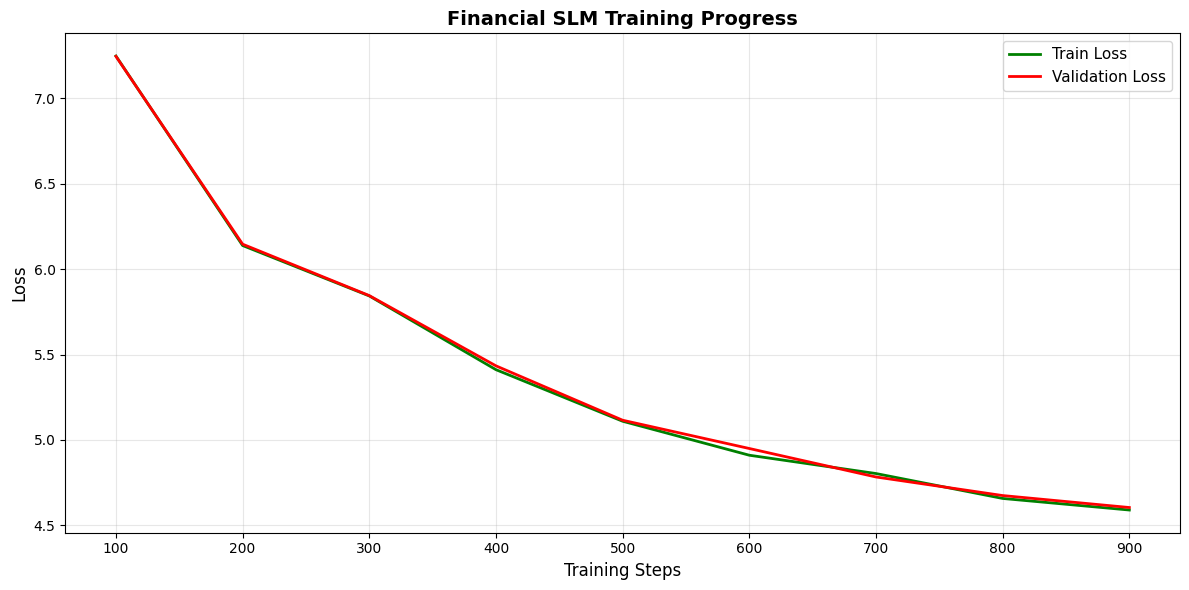


✓ Training curve saved as 'training_loss.png'

📊 Loss Statistics:
   Initial train loss: 7.2487
   Initial val loss: 7.2468
   Final train loss: 4.5892
   Final val loss: 4.6038
   Best val loss: 4.6038
   Total improvement: 2.6430 (36.5%)



In [12]:
import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("VISUALIZING TRAINING RESULTS")
print("=" * 80)

# Convert losses to CPU for plotting
train_losses_cpu = [loss.cpu() if torch.is_tensor(loss) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu() if torch.is_tensor(loss) else loss for loss in val_losses]

# Create loss plot
plt.figure(figsize=(12, 6))
plt.plot(steps_list, train_losses_cpu, 'g-', label='Train Loss', linewidth=2)
plt.plot(steps_list, val_losses_cpu, 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Financial SLM Training Progress', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Training curve saved as 'training_loss.png'")

# Print loss statistics
print(f"\n📊 Loss Statistics:")
print(f"   Initial train loss: {train_losses_cpu[0]:.4f}")
print(f"   Initial val loss: {val_losses_cpu[0]:.4f}")
print(f"   Final train loss: {train_losses_cpu[-1]:.4f}")
print(f"   Final val loss: {val_losses_cpu[-1]:.4f}")
print(f"   Best val loss: {best_val_loss:.4f}")
print(f"   Total improvement: {val_losses_cpu[0] - best_val_loss:.4f} ({(val_losses_cpu[0] - best_val_loss)/val_losses_cpu[0]*100:.1f}%)")

print("\n" + "=" * 80)

### Create Model Card & Save Training Summary

In [ ]:
print("\n" + "=" * 80)
print("CREATING MODEL DOCUMENTATION")
print("=" * 80)

# Create model card
model_card = f"""
# Financial SLM - Model Card

## Model Details
- **Model Name**: Financial Small Language Model (SLM)
- **Model Type**: GPT-2 Fine-tuned Transformer
- **Parameters**: {n_params/1e6:.2f}M
- **Architecture**: {model.config.n_layer} layers, {model.config.n_head} attention heads, {model.config.n_embd} embedding dim
- **Vocabulary**: GPT-2 (50,257 tokens)
- **Training Date**: October 29, 2025

## Training Data
- **Finance Alpaca**: {len(finance_alpaca['train']):,} financial Q&A examples
- **Financial PhraseBank**: {len(financial_phrasebank['train']):,} sentiment analysis examples
- **Custom Investment Data**: {len(custom_dataset)} curated investment examples
- **Total Training Examples**: {len(dataset_split['train']):,}
- **Total Tokens**: {total_tokens:,}

## Training Configuration
- **Optimizer**: AdamW (lr={learning_rate}, weight_decay=0.1)
- **Batch Size**: {batch_size} (effective: {batch_size * gradient_accumulation_steps})
- **Training Steps**: {max_iters:,}
- **Learning Rate Schedule**: Linear warmup ({warmup_steps} steps) + Cosine annealing
- **Mixed Precision**: {dtype}
- **Hardware**: {'GPU' if device_type == 'cuda' else 'CPU'}

## Performance
- **Best Validation Loss**: {best_val_loss:.4f}
- **Evaluations Performed**: {len(train_losses)}

## Capabilities
- Financial question answering
- Investment analysis and recommendations
- Sentiment analysis of financial statements
- Company financial health assessment
- Portfolio diversification advice
- Financial concept explanations

## Limitations
- Educational purposes only - not financial advice
- May generate incorrect or outdated information
- Should not be sole basis for investment decisions
- Requires human verification and professional advice

## Intended Use
- Financial education and learning
- Investment research assistance
- Financial literacy improvement
- Prototype for financial chatbots

## Ethical Considerations
- Always include disclaimers about not being financial advice
- Users should consult licensed financial advisors
- Model outputs should be fact-checked
- Not suitable for automated trading systems

## Citation
If you use this model, please cite:
    Financial SLM (2025)
    {n_params/1e6:.1f}M parameter GPT-2 fine-tuned model for financial analysis
    Trained on Finance Alpaca + Financial PhraseBank + Custom data
"""

# Save model card to file
with open('model_card.md', 'w') as f:
    f.write(model_card)

print("✓ Model card saved: model_card.md")

# Print training summary
print("\n" + "=" * 80)
print("📊 TRAINING SUMMARY")
print("=" * 80)

print(f"\n🔧 Model Configuration:")
print(f"  Total parameters: {n_params:,} ({n_params/1e6:.2f}M)")
print(f"  Layers: {model.config.n_layer}")
print(f"  Attention heads: {model.config.n_head}")
print(f"  Embedding dimension: {model.config.n_embd}")
print(f"  Block size: {block_size}")
print(f"  Vocabulary size: {model.config.vocab_size:,}")

print(f"\n📚 Training Data:")
print(f"  Total training examples: {len(dataset_split['train']):,}")
print(f"  Total test examples: {len(dataset_split['test']):,}")
print(f"  Total tokens: {total_tokens:,}")
print(f"  Avg tokens per example: {total_tokens / len(combined_dataset):.1f}")

print(f"\n⚙️ Training Configuration:")
print(f"  Learning rate: {learning_rate}")
print(f"  Training iterations: {max_iters:,}")
print(f"  Batch size: {batch_size}")
print(f"  Gradient accumulation: {gradient_accumulation_steps}")
print(f"  Effective batch size: {batch_size * gradient_accumulation_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Eval interval: {eval_interval}")
print(f"  Mixed precision: {dtype}")

print(f"\n📈 Training Performance:")
print(f"  Evaluations performed: {len(train_losses)}")
print(f"  Best validation loss: {best_val_loss:.4f}")

if len(train_losses) > 0:
    initial_train = train_losses[0].item() if torch.is_tensor(train_losses[0]) else train_losses[0]
    final_train = train_losses[-1].item() if torch.is_tensor(train_losses[-1]) else train_losses[-1]
    initial_val = val_losses[0].item() if torch.is_tensor(val_losses[0]) else val_losses[0]
    final_val = val_losses[-1].item() if torch.is_tensor(val_losses[-1]) else val_losses[-1]
    
    print(f"  Initial train loss: {initial_train:.4f}")
    print(f"  Final train loss: {final_train:.4f}")
    print(f"  Initial val loss: {initial_val:.4f}")
    print(f"  Final val loss: {final_val:.4f}")
    
    improvement = initial_val - best_val_loss
    improvement_pct = (improvement / initial_val * 100) if initial_val > 0 else 0
    print(f"  Total improvement: {improvement:.4f} ({improvement_pct:.1f}%)")

print(f"\n💾 Files Created:")
print(f"  ✓ best_financial_slm.pt - Model checkpoint")
print(f"  ✓ training_loss.png - Loss curve visualization")
print(f"  ✓ MODEL_CARD.md - Model documentation")

print("\n" + "=" * 80)
print("🎉 ALL STEPS COMPLETE - YOUR FINANCIAL SLM IS READY!")
print("=" * 80)


CREATING MODEL DOCUMENTATION
✓ Model card saved: MODEL_CARD.md

📊 TRAINING SUMMARY

🔧 Model Configuration:
  Total parameters: 124,439,808 (124.44M)
  Layers: 12
  Attention heads: 12
  Embedding dimension: 768
  Block size: 256
  Vocabulary size: 50,257

📚 Training Data:
  Total training examples: 57,613
  Total test examples: 14,404
  Total tokens: 9,599,155
  Avg tokens per example: 133.3

⚙️ Training Configuration:
  Learning rate: 5e-05
  Training iterations: 1,000
  Batch size: 16
  Gradient accumulation: 8
  Effective batch size: 128
  Warmup steps: 100
  Eval interval: 100
  Mixed precision: bfloat16

📈 Training Performance:
  Evaluations performed: 9
  Best validation loss: 4.6038
  Initial train loss: 7.2487
  Final train loss: 4.5892
  Initial val loss: 7.2468
  Final val loss: 4.6038
  Total improvement: 2.6430 (36.5%)

💾 Files Created:
  ✓ best_financial_slm.pt - Model checkpoint
  ✓ training_loss.png - Loss curve visualization
  ✓ MODEL_CARD.md - Model documentation

🎉 A